In [1]:
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.join('./', 'nlmpy'))
from nlmpy import nlmpy
import numpy as np
import itertools
import random

# Using Cons Bio Paper Landscape Sim Method: TODO

# Using NLMPY

In [2]:
RANDSEED = 1357
random.seed(RANDSEED)
np.random.seed(RANDSEED)

In [3]:
NUM_ROWS = 50
NUM_COLS = 50

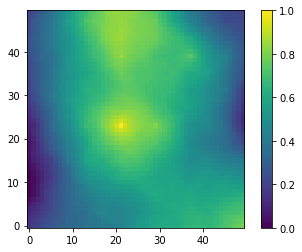

In [4]:
rastervals = nlmpy.mpd(NUM_ROWS, NUM_ROWS, 1.5)
# rastervals = (rastervals - np.mean(rastervals)) / np.std(rastervals) # should we standardize?
plt.imshow(rastervals, origin='lower')
plt.colorbar()

# Test Generated Raster with Simulation Code

## Simulate individual activity centers

In [5]:
def lambda_ipp_log_linear(x, beta0, beta1):
    """
    Rate function for an inhomogeneous poisson process, in which
    the intensity is a log-linear function of x.

    lambda = exp(beta0 + beta1*x)
    """
    return np.exp(beta0 + beta1*x)


def simulate_ipp(N, raster, n_real=1, seed=1111):
    """
    Simulates a spatial inhomogeneous Poisson process over 2D raster.
    Simulation is done using the Lewis and Schedler thinning algorithm.

    Args:
    N           - number of point events to simulate per realizition
    raster      - raster over which to simulate the IPP
    n_real      - number of realizations of the IPP to simulate
    seed        - random seed for the simulation

    Returns:
    points      - list of n_real lists; each sublist contains N tuples (x, y) specifying spatial 
                  points for one realization of the IPP.
    """
    np.random.seed(seed)

    n_pixels = np.prod(raster.shape)
    beta0 = np.log(float(N)/n_pixels)
    beta1 = -3
    min_rast_val = np.amin(raster)
    max_rast_val = np.amax(raster)
    lambda_max = max(lambda_ipp_log_linear(min_rast_val, beta0, beta1), lambda_ipp_log_linear(max_rast_val, beta0, beta1))
    
    points = [] # list points in each realization of the IPP
    for rno in range(n_real):
        counter = 0
        rpoints = [] # list of points for a single IPP realization
        while counter < N:
            x_coord = np.random.uniform(0, raster.shape[0], 1)[0]
            y_coord = np.random.uniform(0, raster.shape[1], 1)[0]
            z_val = raster[int(np.floor(x_coord)), int(np.floor(y_coord))]
            lambda_xy = lambda_ipp_log_linear(z_val, beta0, beta1)
            coin = np.random.uniform(0, 1, 1)[0]
            if coin < lambda_xy/lambda_max:
                counter += 1
                rpoints.append((x_coord, y_coord))
        points.append(rpoints)
    return points

In [6]:
ac_realizations = simulate_ipp(100, rastervals, n_real=1, seed=RANDSEED)


(0.0, 50.0)

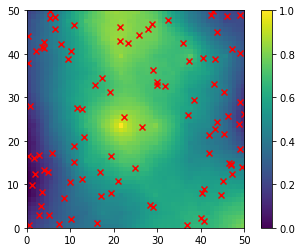

In [7]:
plt.imshow(rastervals, origin='lower', extent=(0, NUM_ROWS, 0, NUM_COLS))
plt.colorbar()
ac_x_coords = [t[0] for t in ac_realizations[0]]
ac_y_coords = [t[1] for t in ac_realizations[0]]
plt.scatter(ac_y_coords, ac_x_coords, c='r', marker='x')
plt.xlim([0, NUM_ROWS])
plt.ylim([0, NUM_COLS])

## Create grid layout for detectors

In [8]:
def create_grid_layout(n, m, raster, buffer=0.1):
    n_pix_h, n_pix_w = raster.shape
    grid_xmin = n_pix_h*buffer
    grid_xmax = n_pix_h*(1-buffer)
    grid_ymin = n_pix_w*buffer
    grid_ymax = n_pix_w*(1-buffer)

    grid_x = np.linspace(grid_xmin, grid_xmax, n)
    grid_y = np.linspace(grid_ymin, grid_ymax, m)
    grid_loc = list(itertools.product(grid_x, grid_y))

    return grid_loc

In [9]:
# the real-world trap config has 67 traps (prime number!)
# for approx comparison here we use 66 traps in a grid layout
# then, we can compare this grid layout with the real-world layout on this simulated landscape
grid_trap_loc = create_grid_layout(11, 6, rastervals)


Text(0, 0.5, 'Raster Cell Coords in Latitude Direction')

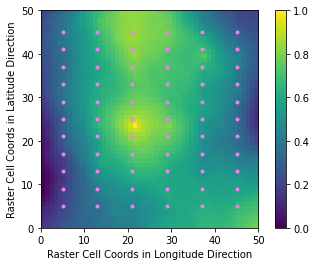

In [10]:
plt.imshow(rastervals, origin='lower', extent=(0, NUM_ROWS, 0, NUM_COLS))
plt.colorbar()
trap_x_coords = [t[0] for t in grid_trap_loc]
trap_y_coords = [t[1] for t in grid_trap_loc]
plt.scatter(trap_y_coords, trap_x_coords, c='violet', marker='.')
plt.xlim([0, NUM_ROWS])
plt.ylim([0, NUM_COLS])
plt.xlabel('Raster Cell Coords in Longitude Direction')
plt.ylabel('Raster Cell Coords in Latitude Direction')

(0.0, 50.0)

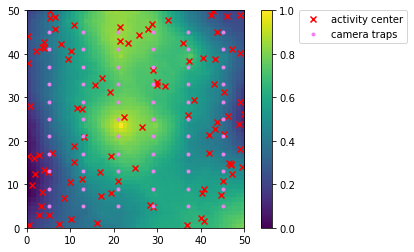

In [11]:
# Visualize together
plt.imshow(rastervals, origin='lower', extent=(0, NUM_ROWS, 0, NUM_COLS))
plt.colorbar()
trap_x_coords = [t[0] for t in grid_trap_loc]
trap_y_coords = [t[1] for t in grid_trap_loc]
plt.scatter(ac_y_coords, ac_x_coords, c='r', marker='x', label='activity center')
plt.scatter(trap_y_coords, trap_x_coords, c='violet', marker='.', label='camera traps')
plt.legend(loc=(1.25,0.85))
plt.xlim([0, NUM_ROWS])
plt.ylim([0, NUM_COLS])

## Load trap locations from file

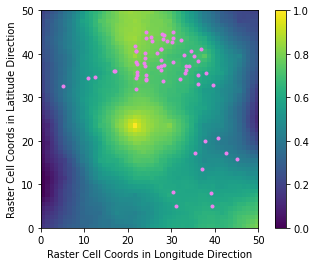

In [12]:
import pandas as pd
data = pd.read_csv('../sebangau lat long 1 loc.csv')

# LATITUDE AND LONGITUDE COLUMN NAMES ARE MIXED UP
# CORRECT HERE
data['Longitude_tmp'] = data['Longitude']
data['Longitude'] = data['Latitude']
data['Latitude'] = data['Longitude_tmp']
del data['Longitude_tmp']

max_latitude = data['Latitude'].max()
min_latitude = data['Latitude'].min()
max_longitude = data['Longitude'].max()
min_longitude = data['Longitude'].min()

# Convert each longitude value into an x coordinate in the range [0,50)
# and each longitude value into a y coordinate in the range [0,50)
# NOTE: to avoid edge-effects, place traps in the middle 80% of the square
trap_x_coords = []
for lon in data['Longitude']:
    rasterv = ((lon-min_longitude)/(max_longitude-min_longitude)) * 0.8*NUM_COLS + 0.1*NUM_COLS
    trap_x_coords.append(rasterv)
trap_y_coords = []
for lat in data['Latitude']:
    rasterv = ((lat-min_latitude)/(max_latitude-min_latitude)) * 0.8*NUM_ROWS + 0.1*NUM_ROWS
    trap_y_coords.append(rasterv)

# Plot
plt.imshow(rastervals, origin='lower', extent=(0, NUM_ROWS, 0, NUM_COLS))
plt.colorbar()
plt.scatter(trap_y_coords, trap_x_coords, c='violet', marker='.')
plt.xlim([0, NUM_ROWS])
plt.ylim([0, NUM_COLS])
plt.xlabel('Raster Cell Coords in Longitude Direction')
plt.ylabel('Raster Cell Coords in Latitude Direction')

# Gather trap locations as a list of tuples
# (same format as grid trap layout generator)
real_trap_loc = list(zip(trap_x_coords, trap_y_coords))


In [13]:
data.head()

,Longitude,Latitude
0,113.88552,-2.31778
1,113.88971,-2.30993
2,113.88175,-2.30771
3,113.88845,-2.31236
4,113.88286,-2.31236


(0.0, 50.0)

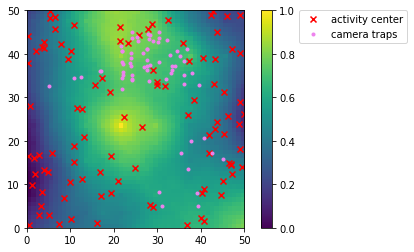

In [14]:
# Visualize together
plt.imshow(rastervals, origin='lower', extent=(0, NUM_ROWS, 0, NUM_COLS))
plt.colorbar()
trap_x_coords = [t[0] for t in real_trap_loc]
trap_y_coords = [t[1] for t in real_trap_loc]
plt.scatter(ac_y_coords, ac_x_coords, c='r', marker='x', label='activity center')
plt.scatter(trap_y_coords, trap_x_coords, c='violet', marker='.', label='camera traps')
plt.legend(loc=(1.25,0.85))
plt.xlim([0, NUM_ROWS])
plt.ylim([0, NUM_COLS])

In [15]:
import rasterio
from utils import find_lcp_to_pts
def simulate_capture_histories(ac, tl, K, lcp_dist, alpha0, alpha1, n_real=50, seed=1111):
    """
    Simulates a capture history for a simulated spatial capture-recapture study.
    Assumes multiple individuals can be detected at each detector in a given sampling
    occasion--but multiple detections of the same individual at the same trap in a
    single sampling occasion are indistinguishable.
    Args:
    ac          - list of tuples (x,y) storing activity center locations
    tl          - list of tuples (x,y) storing trap locations
    K           - number of sampling occasions
    lcp_dist    - least cost paths between each trap and every raster pixel
    alpha0      - capture probability parameter
    alpha1      - home range parameter
    n_real      - number of realizations of the capture history to simulate
    seed        - random seed for the simulation
    Returns:
    detections  - matrix of the number of times each individual was detected at
                  each detector
    """
    n_individuals = len(ac)
    n_traps = len(tl)
    detections = []
    for rno in range(n_real):
        rdetections = np.ndarray((n_individuals, n_traps))
        for ni in range(len(ac)):
            s = ac[ni]
            sx = int(np.floor(s[0]))
            sy = int(np.floor(s[1]))
            for nt in range(len(tl)):
                dist = lcp_dist[nt, sx, sy]
                prob_cap = (1/(1+np.exp(alpha0)))*np.exp(-alpha1*dist*dist)
                n_det = np.random.binomial(K, prob_cap)
                rdetections[ni, nt] = n_det
        rdetections = rdetections[~np.all(rdetections==0, axis=1)]
        detections.append(rdetections)
    return(detections)

In [16]:
ALPHA0 = 0.05
ALPHA1 = 0.15
ALPHA2 = 2.25
RASTER_CELL_SIZE = 0.25


In [17]:
grid_lcp_distances = find_lcp_to_pts(rastervals, 
                                     ALPHA2, grid_trap_loc, 
                                     raster_cell_size=RASTER_CELL_SIZE)
grid_layout_capture_histories = simulate_capture_histories(ac_realizations[0], 
                                                           grid_trap_loc, 10, 
                                                           grid_lcp_distances, 
                                                           ALPHA0, ALPHA1, n_real=1)

real_lcp_distances = find_lcp_to_pts(rastervals, 
                                     ALPHA2, real_trap_loc, 
                                     raster_cell_size=RASTER_CELL_SIZE)
real_layout_capture_histories = simulate_capture_histories(ac_realizations[0], 
                                                           real_trap_loc, 10, 
                                                           real_lcp_distances, 
                                                           ALPHA0, ALPHA1, n_real=1)


In [18]:
print(grid_layout_capture_histories[0].shape)
print(real_layout_capture_histories[0].shape)

(89, 66)
(39, 67)


In [19]:
def num_total_detections_per_trap(cap_hist):
    return [int(s) for s in np.sum(cap_hist, axis=0)]

def num_unique_detections_per_trap(cap_hist):
    return np.sum(cap_hist>0, axis=0)

In [20]:
simulation_no = 0

print('Grid Trap Layout:')
print('\tNumber of detections per trap:')
grid_tot = num_total_detections_per_trap(grid_layout_capture_histories[simulation_no])
print(grid_tot)
print('\tNumber of unique individuals detected per trap:')
grid_unique = num_unique_detections_per_trap(grid_layout_capture_histories[simulation_no])
print(grid_unique)

print('\nReal Trap Layout:')
print('\tNumber of detections per trap:')
real_tot = num_total_detections_per_trap(real_layout_capture_histories[simulation_no])
print(real_tot)
print('\tNumber of unique individuals detected per trap:')
real_unique = num_unique_detections_per_trap(real_layout_capture_histories[simulation_no])
print(real_unique)

Grid Trap Layout:
	Number of detections per trap:
[34, 5, 1, 7, 1, 3, 50, 9, 12, 0, 0, 7, 37, 8, 2, 0, 0, 20, 29, 1, 1, 0, 1, 19, 11, 3, 0, 0, 4, 22, 6, 4, 3, 0, 6, 26, 4, 3, 0, 1, 4, 11, 1, 1, 1, 12, 0, 13, 10, 0, 0, 3, 4, 7, 21, 1, 4, 0, 1, 12, 14, 1, 4, 3, 0, 22]
	Number of unique individuals detected per trap:
[14  4  1  2  1  1 17  4  3  0  0  3 12  4  2  0  0  7 13  1  1  0  1  9
  8  2  0  0  4 10  3  2  1  0  2  9  2  2  0  1  2  5  1  1  1  4  0  5
  4  0  0  1  1  5  7  1  2  0  1  6  7  1  2  2  0  7]

Real Trap Layout:
	Number of detections per trap:
[4, 2, 4, 1, 0, 13, 6, 23, 0, 5, 0, 0, 0, 1, 5, 0, 0, 4, 0, 11, 8, 11, 2, 0, 1, 0, 3, 1, 0, 0, 1, 3, 6, 3, 0, 0, 2, 0, 0, 4, 0, 0, 5, 3, 0, 0, 2, 1, 1, 2, 0, 0, 0, 0, 2, 5, 0, 0, 0, 3, 1, 0, 0, 6, 0, 0, 0]
	Number of unique individuals detected per trap:
[3 1 2 1 0 6 4 8 0 4 0 0 0 1 1 0 0 3 0 2 4 2 2 0 1 0 1 1 0 0 1 1 3 2 0 0 1
 0 0 2 0 0 2 2 0 0 1 1 1 2 0 0 0 0 2 2 0 0 0 1 1 0 0 2 0 0 0]


In [21]:
data['Total Detections'] = real_tot
data['Unique Detections'] = real_unique
data.to_csv('sebangau_real_layout_caphist_summary.csv')
data.head()


,Longitude,Latitude,Total Detections,Unique Detections
0,113.88552,-2.31778,4,3
1,113.88971,-2.30993,2,1
2,113.88175,-2.30771,4,2
3,113.88845,-2.31236,1,1
4,113.88286,-2.31236,0,0


In [22]:
# Save the grid layout results also

# First, convert grid coordinates to same lat-long range as real trap locations
grid_trap_lon = []
grid_trap_lat = []
for x,y in grid_trap_loc:
    lon = (max_longitude-min_longitude)*(x/NUM_COLS) + min_longitude
    grid_trap_lon.append(lon)
    lat = (max_latitude-min_latitude)*(y/NUM_ROWS) + min_latitude
    grid_trap_lat.append(lat)

grid_data = pd.DataFrame()
grid_data['Longitude'] = grid_trap_lon
grid_data['Latitude'] = grid_trap_lat
grid_data['Total Detections'] = grid_tot
grid_data['Unique Detections'] = grid_unique
data.to_csv('sebangau_grid_layout_caphist_summary.csv')
grid_data.head()

,Longitude,Latitude,Total Detections,Unique Detections
0,113.817061,-2.348207,34,14
1,113.817061,-2.339738,5,4
2,113.817061,-2.331269,1,1
3,113.817061,-2.322801,7,2
4,113.817061,-2.314332,1,1
